In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy
from scipy import signal
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rc('font', family='serif')
#plt.style.use('seaborn-white',)
#rc('text', usetex=True)     #this CAN cause crashes, solution: cd ~/.matplotlib  then  rm tex.cache/
sns.set_style("whitegrid")

In [2]:
def exp_fit(r, L, a,b):
    return a*np.exp(-r/L)+b

# Read data and plot an extract of the data

In [14]:
time_series = np.loadtxt('../Data/k10mf_processed_FD2.txt')#[:100000] 


In [15]:
length*5.0*10**(-5)

1.0

In [8]:
length = 20000 # plot 20000 data points
t = np.linspace(0, length*5.0*10**(-5), length)
plt.plot(t,time_series[:length])
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$u(t)$', fontsize=18)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

(array([5.8, 6. , 6.2, 6.4, 6.6, 6.8, 7. ]),
 <a list of 7 Text major ticklabel objects>)

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>

# Calculate mean, standard deviation, and turbulence intensity

$\textrm{mean:}\;\; U=\langle u(t)\rangle \quad \textrm{std:}\;\; \sigma_u=\langle (u(t)- \langle u(t)\rangle)^2\rangle \quad \textrm{turbulence intensity:}\;\; \frac{\sigma_u}{U} \;\; $

In [5]:
mean = np.mean(time_series)
std = np.std(time_series)
ti = std/mean
print('mean:',mean, 'std:', std, 'TI:', ti)

mean: 6.392192612716187 std: 0.15865991586212538 TI: 0.024820890964158106


# Calculate the correlation function and determine integral and Taylor length

$ \textrm{Use Taylor's hypothesis:} \;\; r = U t,\quad \textrm{correlation function:}\;\; C(r) = \langle u'(x+r)u'(x) \rangle\\
\textrm{Taylor length:}\;\; \lambda=\sqrt{-\frac{C''(0)}{C(0)}}, \quad \textrm{integral length scale} \;\; C(r)\sim e^{-r/L}$

In [6]:
N_corr = 20000; # length of correlation function
dr = 5.*10**(-5)
time_series_zero = time_series -  mean # fluctuations
corr = np.zeros(N_corr)
corr[0] = np.mean(time_series_zero**2)
for rr in range(1,N_corr):
    corr[rr] = np.mean(time_series_zero[rr:]*time_series_zero[:-rr]) # this is faster than np.roll(time_series_zero,rr)[rr:]

In [7]:
r = mean * np.linspace(0, N_corr*5.*10**(-5), N_corr) # Taylor hypothesis
cutoff = 8 # no. sample points to calculate Taylor length, has to be determined from minimizing \sqrt cov[0], see below
p, cov = np.polyfit(r[:cutoff], corr[:cutoff]/corr[0], 2, cov=True) # parabolic fit at origin 
L_start = 400
popt, pcov = curve_fit(exp_fit, r[L_start:], corr[L_start:]/corr[0], absolute_sigma=True)
print(popt, np.sqrt(np.diag(pcov)))
print('Taylor length:', np.sqrt(-corr[0]/p[0]), 'integral length exp-fit', popt[0], 'integral length integral', np.sum(corr/corr[0])*dr)

[0.30728835 0.31336796 0.01324693] [0.1435802  0.14555732 0.00796716]
Taylor length: 0.0026423527464801144 integral length exp-fit 0.30728834617113326 integral length integral 0.032963459051886


(<matplotlib.patches.Rectangle at 0x11c624c88>,
 (<matplotlib.patches.ConnectionPatch at 0x11c637710>,
  <matplotlib.patches.ConnectionPatch at 0x11c624780>))

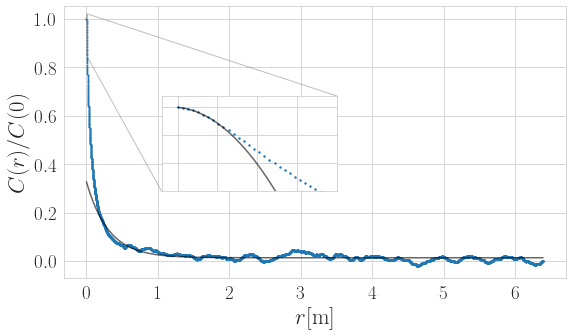

In [8]:
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(r,corr/corr[0], s=0.5) # auto-correlation
ax.plot(r, exp_fit(r, *popt),color='black', alpha=0.6)
ax.set_xlabel('$r [\\textrm{m}]$', fontsize=23)
ax.set_ylabel('$C(r)/C(0)$', fontsize=23)
#ax.legend(fontsize=17)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
axins = ax.inset_axes([0.195, 0.3195, 0.35, 0.35])
add = 20
axins.plot(r[:cutoff+add], p[0]*r[:cutoff+add]**2+p[1]*r[:cutoff+add]+p[2], color='black', alpha=0.6)
axins.scatter(r,corr/corr[0], s=2)
x1, x2, y1, y2 = -0.001, 0.01, 0.85, 1.02
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
#plt.tight_layout()
ax.indicate_inset_zoom(axins)

# Calculate the structure functions 

In [9]:
R_struc = np.logspace(0.6, 3.5, 50, dtype='int')
L = popt[0] # take integral length scale from exp-fit
struc = np.zeros((7,np.size(R_struc)))
for nn in range(1,7):
    for rr in range(np.size(R_struc)):
        struc[nn,rr] = np.mean((time_series[:-R_struc[rr]]-time_series[R_struc[rr]:])**nn)

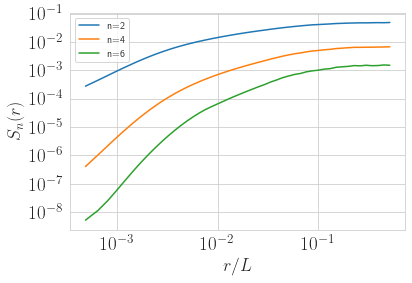

In [10]:
# even structure functions
plt.plot(R_struc*dr/L,struc[2], label='n=2')
plt.plot(R_struc*dr/L,struc[4], label='n=4')
plt.plot(R_struc*dr/L,struc[6], label='n=6')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$r/L$', fontsize=18)
plt.ylabel('$S_n(r)$', fontsize=18)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.legend()
plt.savefig('even_struc.pdf', bbox_inches='tight')

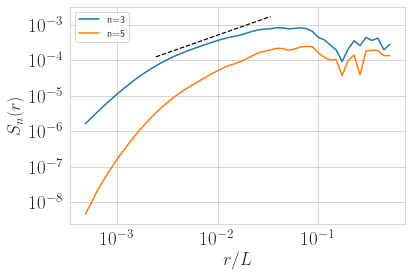

In [11]:
# odd structure functions
plt.plot(R_struc*dr/L,-(struc[3]), label='n=3')
plt.plot(R_struc*dr/L,-(struc[5]), label='n=5')
plt.plot(R_struc[10:30]*dr/L,R_struc[10:30]/120000., linestyle='dashed', color='black', lw=1.2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$r/L$', fontsize=18)
plt.ylabel('$S_n(r)$', fontsize=18)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.legend()

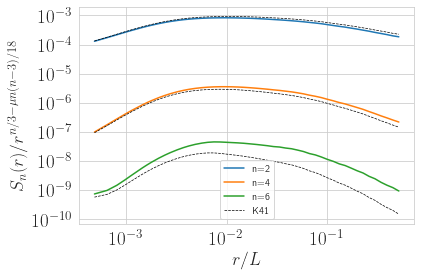

In [12]:
# even structure functions
mu =0.227
plt.plot(R_struc*dr/L,struc[2]/R_struc**(2/3+mu/9) , label='n=2')
plt.plot(R_struc*dr/L,struc[2]/R_struc**(2/3) , color='black', ls='dashed', lw=0.7)
plt.plot(R_struc*dr/L,struc[4]/R_struc**(4/3-2*mu/9), label='n=4')
plt.plot(R_struc*dr/L,struc[4]/R_struc**(4/3), color='black', ls='dashed', lw=0.7)
plt.plot(R_struc*dr/L,struc[6]/R_struc**(6/3-mu), label='n=6')
plt.plot(R_struc*dr/L,struc[6]/R_struc**(6/3), color='black', ls='dashed', lw=0.7, label='K41')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$r/L$', fontsize=18)
plt.ylabel('$S_n(r)/r^{n/3-\mu n (n-3)/18}$', fontsize=18)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.legend()

# PDF

In [13]:
R_pdf = np.array([10, 20, 50, 100, 200, 1000, 2000])
bins = 64 # bins of histogram
pdf = np.zeros((np.size(R_pdf), bins))
std_inc = np.zeros(np.size(R_pdf))
u_max = 0.8
length_extract = 5000
inc_extract = np.zeros((np.size(R_pdf), length_extract))
for rr in range(np.size(R_pdf)):
    inc = time_series[:-R_pdf[rr]]-time_series[R_pdf[rr]:]
    print(np.max(inc))
    std_inc[rr] = np.std(inc)
    pdf[rr], edges = np.histogram(inc, bins=bins, range=[-u_max,u_max])
    pdf[rr] /= np.sum(pdf[rr])
    inc_extract[rr] = inc[:length_extract]

0.3680000000000003
0.5579999999999998
0.8580000000000005
0.7789999999999999
0.8680000000000003
0.8920000000000003
0.8490000000000002


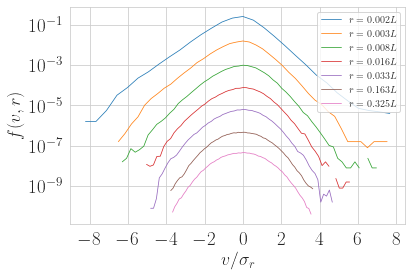

In [14]:
pdf = np.ma.masked_where(pdf ==0, pdf)
for rr in range(np.size(R_pdf)):
    plt.plot(edges[:-1]/std_inc[rr], pdf[rr]*10**(-rr),  label='$r= {0:.3f}$'.format(R_pdf[rr]*dr/L)+'$L$', lw = 0.75)
plt.yscale('log')
plt.xlabel('$v/\sigma_r$', fontsize=18)
plt.ylabel('$f(v,r)$', fontsize=18)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.legend()
plt.savefig('PDF_LCA.pdf', bbox_inches='tight')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


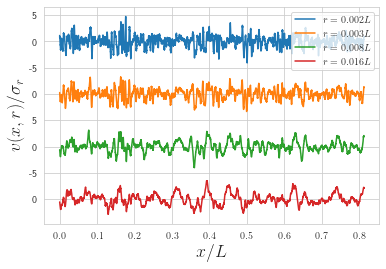

In [15]:
fig, ax = plt.subplots()
for rr in range(np.size(R_pdf)-3):
    ax.plot(np.arange(length_extract)*dr/L, inc_extract[rr]/std_inc[rr]-10*rr, label='$r= {0:.3f}$'.format(R_pdf[rr]*dr/L)+'$L$')
#plt.yticks()
#plt.yticks(fontsize=19)
ax.legend()
ax.set_yticklabels([5,0,-5,0,5,0,-5,0,5])
plt.xlabel('$x/L$', fontsize=18)
plt.ylabel('$v(x,r)/\\sigma_r$', fontsize=18)
plt.savefig('inc_series.pdf', bbox_inches='tight')

# Local energy dissipation rate

In [19]:
nu = 0.15*10**(-4.) # viscosity of air
eps = 2*nu*np.gradient(time_series, dr)**2
eps_ave = np.mean(eps)
eta = (nu**3/eps_ave)**0.25
print('averaged local energy dissipation rate', eps_ave, 'Taylor length', np.sqrt(15*nu/eps_ave)*std)
print('Kolmogorov microscale', eta)

averaged local energy dissipation rate 0.4424259494682311 Taylor length 0.003577982259570481
Kolmogorov microscale 0.0002955345746551481


Text(0, 0.5, '$\\varepsilon(x)/\\sigma_{\\varepsilon}$')

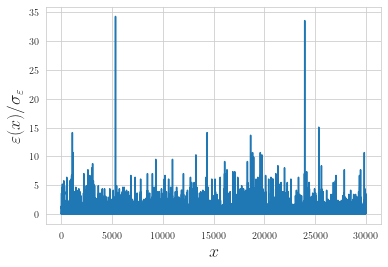

In [20]:
plt.plot(eps[:30000]/np.std(eps[:30000])) # here, we observe that the mean is dominated by two events
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$\\varepsilon(x)/\\sigma_{\\varepsilon}$', fontsize=18)

# Calculate energy dissipation rate averaged over "ball"

$ \varepsilon_r(x)=\int_x^{x+r} \textrm{d}x' \varepsilon(x')$

In [21]:
R = np.array([10, 200, 1000, 5000, 10000])
bins = 128
hist_eps = np.zeros((R.size,bins))
eps_edges = np.zeros((R.size,bins+1))
std_eps = np.zeros(R.size)
for rr in range(R.size):
    eps_r = np.cumsum(np.roll(eps,R[rr])[R[rr]:])*dr - np.cumsum(eps[R[rr]:])*dr
    hist_eps[rr] , eps_edges[rr] = np.histogram(eps_r, bins=bins)
    std_eps[rr] = np.std(eps_r)

(-20.0, 4.0)

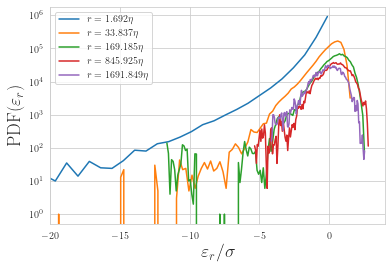

In [22]:
for rr in range(R.size):
    plt.plot(eps_edges[rr][:-1]/std_eps[rr], hist_eps[rr], label='$r= {0:.3f}$'.format(R[rr]*dr/eta)+'$\\eta$')
plt.yscale('log')
plt.xlabel('$\\varepsilon_r/\\sigma$', fontsize=18)
plt.ylabel('$\\textrm{PDF}(\\varepsilon_r)$', fontsize=18)
plt.legend()
plt.xlim(-20, 4)

# energy spectrum E(k)

In [126]:
u_hat = np.fft.rfft(time_series)/np.size(time_series)*20
k = np.linspace(0, 20*1000/2, np.size(time_series)//2+1)
spec = np.abs(u_hat**2)
f, Pxx_den = signal.welch(time_series, fs=20*1000, nperseg=30000) # windowed estimated according to integral length scale with nperseg
#f, Pxx_averaged = signal.welch(time_series, fs=20*1000, average='median')

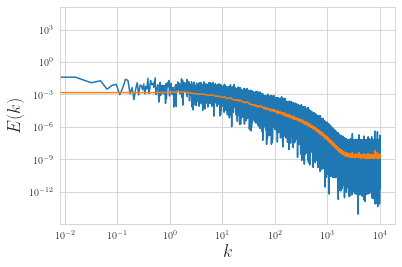

In [127]:
plt.plot(k,spec)
plt.plot(f,Pxx_den)
plt.xlabel('$k$', fontsize=18)
plt.ylabel('$E(k)$', fontsize=18)
#plt.plot(f,Pxx_averaged)
plt.xscale('log')
plt.yscale('log')